In [1]:
import casadi as ca
import numpy as np
from mpc_model import Model
from mpc_simulation import  Simulator
from mpc_solver import MPC
from mpc_plot import Plot
import matplotlib.pyplot as plt

## Furuta Pendulum

$$
\begin{array}{r}
\left(\alpha+\beta \sin ^{2} \theta\right) \ddot{\phi}+\gamma \cos \theta \ddot{\theta}+2 \beta \cos \theta \sin \theta \dot{\phi} \dot{\theta}-\gamma \sin \theta \dot{\theta}^{2}=\tau_{\phi} \\
\gamma \cos \theta \ddot{\phi}+\beta \ddot{\theta}-\beta \cos \theta \sin \theta \dot{\phi}^{2}-\delta \sin \theta=\tau_{\theta}
\end{array}
$$

### State space model
$$x_1 = \phi, x_2 = \dot{\phi} , x_3 = \theta, x_4 = \dot{\theta}, u_1 = \tau_{\phi}, u_2 = \tau_{\theta}$$

$$
\begin{aligned}
\frac{dx_1}{dt} &= x_2\\
\frac{dx_2}{dt}  &=\frac{1}{\alpha \beta-\gamma^{2}+\left(\beta^{2}+\gamma^{2}\right) \sin ^{2} x_3}\left\{\beta \gamma\left(\sin ^{2} x_3-1\right) \sin x_3 x_2^{2}-2 \beta^{2} \cos x_3 \sin x_3 x_2 x_4+\beta \gamma \sin x_3 x_4^{2}-\gamma \delta \cos x_3 \sin x_3+\beta u_1-\gamma \cos x_3 u_2\right\} \\
\frac{dx_3}{d t} &=x_4 \\
\frac{dx_4}{d t} &=\frac{1}{\alpha \beta-\gamma^{2}+\left(\beta^{2}+\gamma^{2}\right) \sin ^{2} x_3}\left\{\beta\left(\alpha+\beta \sin ^{2} x_3\right) \cos x_3 \sin x_3 x_2^{2}+2 \beta \gamma\left(1-\sin ^{2} x_3\right) \sin x_3 x_2 x_4-\gamma^{2} \cos x_3 \sin x_3 x_4^{2}+\delta\left(\alpha+\beta \sin ^{2} x_3\right) \sin x_3-\gamma \cos x_3 u_1+\left(\alpha+\beta \sin ^{2} x_3\right) u_2\right\}
\end{aligned}
$$


In [2]:
def furuta_ode(t, x, u, p):
    """
    Furuta Pendulum
    """
    # Parameter configuration
    alpha = p[0]
    beta =  p[1]
    delta = p[2]
    gamma = p[3]

    dx1_dt = x[1]
    dx2_dt = 1 / (alpha * beta - gamma ** 2 + (beta ** 2 + gamma ** 2) * ca.sin(x[2]) ** 2) * (
                beta * gamma * (ca.sin(x[2] ** 2 - 1)) * ca.sin(x[2]) * x[1] ** 2 - 2 * beta ** 2 * ca.cos(
            x[2]) * ca.sin(x[2]) * x[1] * x[3] + beta * gamma * ca.sin(x[2]) * x[3] ** 2 - gamma * delta * ca.cos(
            x[2]) * ca.sin(x[2]) + beta * u[0] - gamma * ca.cos(x[2]) * u[1])
    dx3_dt = x[3]
    dx4_dt = 1 / (alpha * beta - gamma ** 2 + (beta ** 2 + gamma ** 2) * ca.sin(x[2]) ** 2) * (
                beta * (alpha + beta * ca.sin(x[2]) ** 2) * ca.cos(x[2]) * ca.sin(x[2]) * x[
            1] ** 2 + 2 * beta * gamma * (1 - ca.sin(x[2]) ** 2) * ca.sin(x[2]) * x[1] * x[3] - gamma ** 2 * ca.cos(
            x[2]) * ca.sin(x[2]) * x[3] ** 2 + delta * (alpha + beta * ca.sin(x[2]) ** 2) * ca.sin(
            x[2]) - gamma * ca.cos(x[2]) * u[0] + (alpha + beta * ca.sin(x[2]) ** 2) * u[1])

    rhs = [dx1_dt,
           dx2_dt,
           dx3_dt,
           dx4_dt
           ]
    return ca.vertcat(*rhs)

In [3]:
def set_constraint(N_pred):
    # set constraint
    lbx = [0, 0, -ca.pi, 0]
    ubx = [0, 0, -ca.pi, 0]
    lbx += [-ca.pi, -ca.inf, -ca.pi, -ca.inf, -ca.inf, -ca.inf] * N_pred
    ubx += [ca.pi, ca.inf, 2 * ca.pi, ca.inf, ca.inf, ca.inf] * N_pred

    x0 = [0, 0, -ca.pi, 0]
    x0 += [0, 0, 0, 0, 0, 0] * N_pred

    lbg = [0, 0, 0, 0] * N_pred
    ubg = [0, 0, 0, 0] * N_pred

    p = [0, 0, 0, 0, 0, 0, 0] # t_var, xr_var, ur_var

    return lbx, ubx, lbg, ubg, p, x0

In [4]:
Nt = 1
Nx = 4
Nu = 2
Np = 0
Nz = 0

delta_t = 0.01
N_pred = 50
N_sim = 100

t_SX = ca.SX.sym("t_SX", Nt)
x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
p_SX = ca.SX.sym("p_SX", Np)
z_SX = ca.SX.sym("z_SX", Nz)

alpha = 0.0033472
beta =  0.0038852
delta = 0.097625
gamma = 0.0024879

para = [alpha,beta,delta,gamma]

furuta_ode(t_SX, x_SX, u_SX, para)
lbx, ubx, lbg, ubg, p, x0 = set_constraint(N_pred)


xr_SX = ca.SX.sym("xr_SX", Nx)
ur_SX = ca.SX.sym("ur_SX", Nu)
Q = np.diag([10, 1, 100, 1])
R = np.diag([1, 1])
Q_f = np.diag([0, 0, 0, 0])
stage_cost = (x_SX - xr_SX).T @ Q @ (x_SX - xr_SX) + (u_SX - ur_SX).T @ R @ (u_SX - ur_SX)    #  Lagrange term
terminal_cost = (x_SX - xr_SX).T @ Q_f @ (x_SX - xr_SX)    #  Mayer term
stage_cost_func = ca.Function("stage_cost_func",[x_SX, xr_SX, u_SX, ur_SX], [stage_cost])
terminal_cost_func = ca.Function("terminal_cost_func",[x_SX, xr_SX], [terminal_cost])

model = Model(t_SX, x_SX, u_SX, z_SX, p_SX, delta_t, para=para, ode=furuta_ode, alg=None, opt=None,
              stage_cost_func=stage_cost_func, terminal_cost_func=terminal_cost_func)

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}
opt = {}
opt['solver_opt'] = solver_opt

mpc_solver = MPC(model, N_pred, opt = opt)
mpc_simulator = Simulator(model, mpc_solver, N_sim, lbx, ubx, lbg, ubg, p, x0)

(304, 1)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



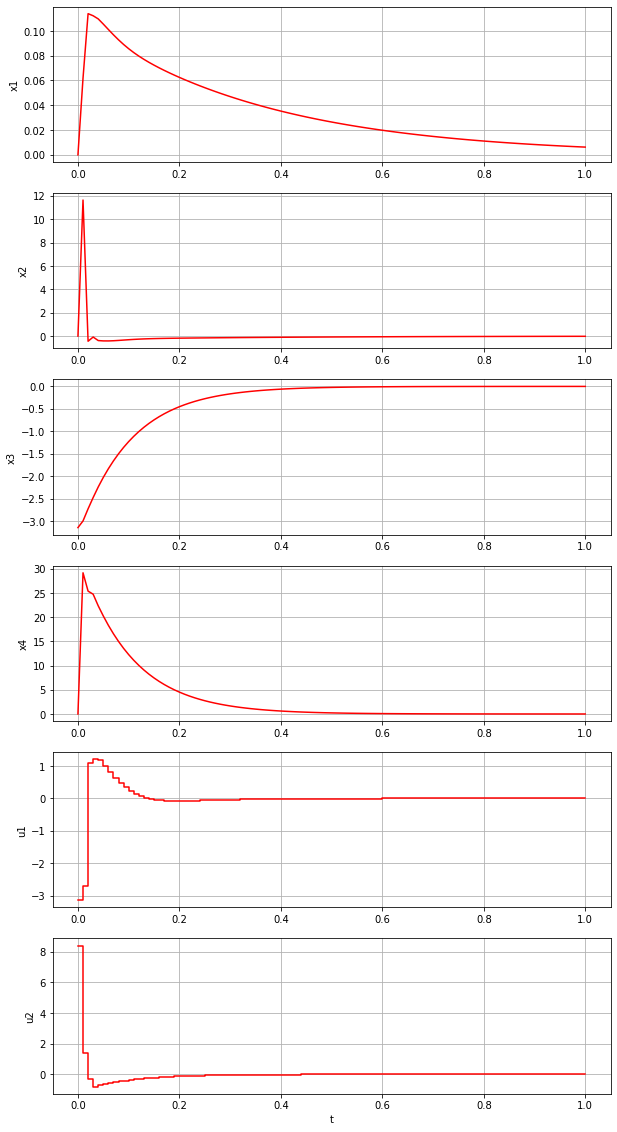

In [5]:
mpc_plot = Plot(mpc_simulator)
mpc_plot.plot_multi()

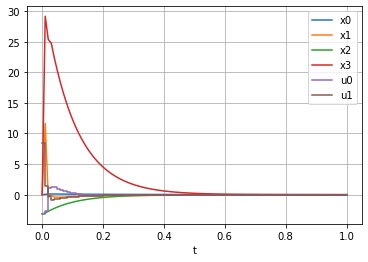

In [6]:
mpc_plot.plot_single()

## Fermination

$$
\begin{aligned}
&\mu_{x}=\frac{\mu_{x 0} s}{0.5 s_{i}+e}\\
&\mu_{D}=\frac{0.5 s_{i} \mu_{D 0}}{0.5 s_{i}+e}\\
&\mu_{s}=\frac{\mu_{s 0} s}{k_{s}+s}\\
&\mu_{a}=\frac{\mu_{a 0} s}{k_{s}+s}\\
&f=1-\frac{e}{0.5 s_{i}}\\
&\frac{d x_{\text {lag} }}{d t}=-\mu_{\text {lag}} x_{\text {lag}}\\
&\frac{d x_{\text {active}}}{d t}=\mu_{x} x_{\text {active}}-k_{m} x_{\text {active}}+\mu_{\text {lag}} x_{\text {lag}}\\
&\frac{d x_{\text {bottom}}}{d t}=k_{m} x_{\text {active}}-\mu_{D} x_{\text {bottom}}\\
&\frac{d s}{d t}=-\mu_{s} x_{\text {active }}\\
&\frac{d e}{d t}=\mu_{a} f x_{\text {active}}\\
&\frac{d(a c e t)}{d t}=\mu_{e a s} \frac{d s}{d t}=- \mu_{e a s} \mu_{s} x_{a c t i v e}\\
&\frac{d(d i a c)}{d t}=k_{d c} s x_{\text {active}}-k_{d m}(\operatorname{diac}) e
\end{aligned}
$$

### Some exponential functions:
$$
\begin{array}{lll}
\mu_{x 0}=e^{108.31-\frac{31934.09}{T+273.15}} & k_{m}=e^{130.16-\frac{38313}{T+273.15}} \\
\mu_{\text {eas}}=e^{89.92-\frac{26589}{T+273.15}} & \mu_{D 0}=e^{33.82-\frac{10033.28}{T+273.15}} \\
\mu_{s 0}=e^{-41.92+\frac{11654.64}{T+273.15}} & \mu_{a 0}=e^{3.27-\frac{1267.24}{T+273.15}} \\
\mu_{\text {lag}}=e^{30.72-\frac{9501.54}{T+273.15}} & k_{s}=e^{-119.63+\frac{34203.95}{T+273.15}} \\
k_{d c}=0.000127672 & k_{d m}=0.00113864
\end{array}
$$

In [7]:
def fermination_ode(t, x, u, p):
    """
    Fermination model
    """
    k_dc = p[0]
    k_dm = p[1]
    s_i = p[2]

    T = u[0]

    x_lag = x[0]
    x_active = x[1]
    x_bottom = x[2]
    s = x[3]
    e = x[4]
    acet = x[5]
    diac = x[6]

    mu_x0 = ca.exp(108.31 - 31934.09 / (T+273.15))
    mu_eas = ca.exp(89.92 - 26589 / (T+273.15))
    mu_s0 = ca.exp( -41.92 + 11654.64/ (T+273.15))
    mu_lag = ca.exp(30.72 - 9501.54 / (T+273.15))
    k_dc = 0.000127672
    k_m = ca.exp( 130.16 - 38313 / (T+273.15))
    mu_D0 = ca.exp( 33.82 - 10033.28/ (T+273.15))
    mu_a0 = ca.exp(3.72 - 1267.24 / (T+273.15))
    k_s = ca.exp(-119.63 + 34203.95 / (T + 273.15))
    k_dm = 0.00113864

    mu_x = mu_x0 * s / (0.5 * s_i + e)
    mu_D = 0.5 * s_i * mu_D0 / (0.5 * s_i + e)
    mu_s = mu_s0 * s / (k_s + s)
    mu_a = mu_a0 * s / (k_s + s)
    f = 1 - e / (0.5 * s_i)

    dx_lag = - mu_lag * x_lag
    dx_active = mu_x * x_active - k_m * x_active + mu_lag * x_lag
    dx_bottom = k_m * x_active - mu_D * x_bottom
    ds = - mu_s * x_active
    de = mu_a * f * x_active
    dacet = - mu_eas * mu_s * x_active
    ddiac = k_dc * s * x_active - k_dm * diac * e
    rhs = [dx_lag,
           dx_active,
           dx_bottom,
           ds,
           de,
           dacet,
           ddiac
           ]
    return ca.vertcat(*rhs)

In [8]:
def set_constraint(Nx, Nu, N_pred):
    # set constraint
    lbx = [1.5, 0, 2, 122.41, 0, 10, 10]
    ubx = [1.5, 0, 2, 122.41, 0, 10, 10]
    lbx += [-ca.inf] * (Nx + Nu) * N_pred
    ubx += [ca.inf] * (Nx + Nu) * N_pred

    x0 = [1.5, 0, 2, 22.41, 0, 0, 0] 
    x0 += [0] * (Nx + Nu) * N_pred

    lbg = [0] * Nx * N_pred
    ubg = [0] * Nx * N_pred

    p = [0, 0, 1, 0, 0, 60, 1.05, 0, 10] # t_var, xr_var, ur_var

    return lbx, ubx, lbg, ubg, p, x0

In [9]:
Nt = 1
Nx = 7
Nu = 1
Np = 0
Nz = 0

delta_t = 1
N_pred = 50
N_sim = 100

t_SX = ca.SX.sym("t_SX", Nt)
x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
p_SX = ca.SX.sym("p_SX", Np)
z_SX = ca.SX.sym("z_SX", Nz)

k_dc = 0.000127672
k_dm =  0.00113864
s_i = 22.41

para = [k_dc, k_dm, s_i]


fermination_ode(t_SX, x_SX, u_SX, para)
lbx, ubx, lbg, ubg, p, x0 = set_constraint(Nx, Nu, N_pred)


xr_SX = ca.SX.sym("xr_SX", Nx)
ur_SX = ca.SX.sym("ur_SX", Nu)

stage_cost = 0.001**(-17) * ca.exp(2.31 * u_SX)   - 100 * (u_SX - ur_SX) #  Lagrange term
terminal_cost = 10 * x_SX[4] - 1.16 * ca.exp(48 * x_SX[5] - 66.77) -5.73 * ca.exp(11 * x_SX[6] - 11.51)    #  Mayer term
stage_cost_func = ca.Function("stage_cost_func",[x_SX, xr_SX, u_SX, ur_SX], [stage_cost])
terminal_cost_func = ca.Function("terminal_cost_func",[x_SX, xr_SX], [terminal_cost])

model = Model(t_SX, x_SX, u_SX, z_SX, p_SX, delta_t, para=para, ode=fermination_ode, alg=None, opt=None,
              stage_cost_func=stage_cost_func, terminal_cost_func=terminal_cost_func)

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}
opt = {}
opt['solver_opt'] = solver_opt

mpc_solver = MPC(model, N_pred, opt = opt)
mpc_simulator = Simulator(model, mpc_solver, N_sim, lbx, ubx, lbg, ubg, p, x0)

(407, 1)


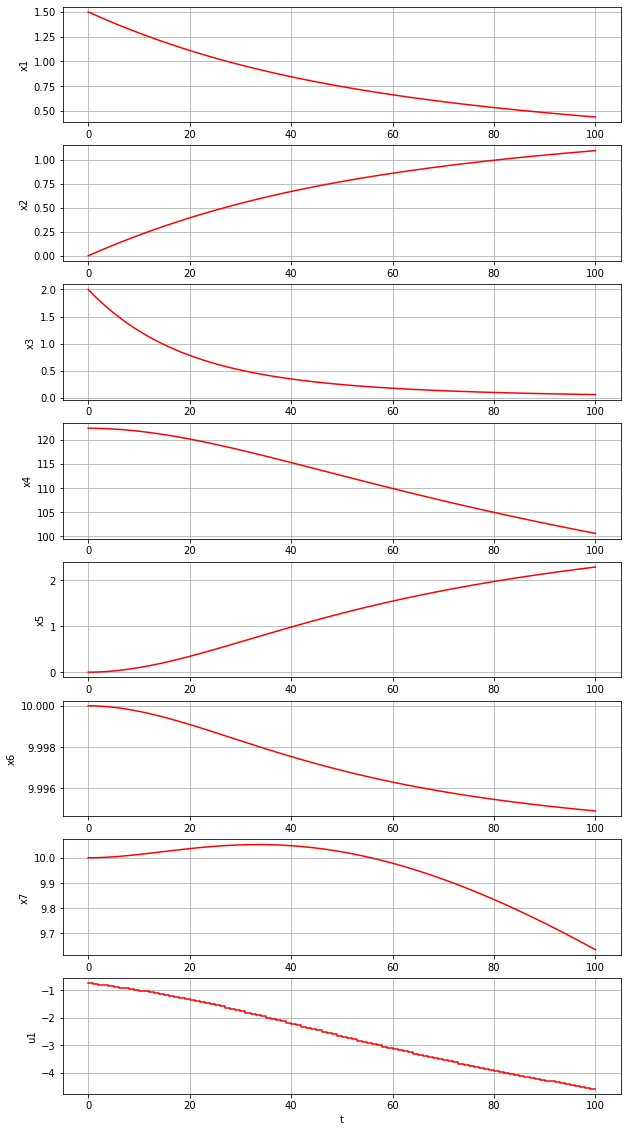

In [10]:
mpc_plot = Plot(mpc_simulator)
mpc_plot.plot_multi()

x1 = x_lag,
x2 = x_active,
x3 = x_bottom,
x4 = s,
x5 = e,
x6 = dacet,
x7 = ddiac

### Mobile robot

In [11]:
def mobile_robot_ode(t, x, u, p = None):
    """
    Mobile robot
    """
    # Parameter configuratio

    dx_dt = u[0] * ca.cos(x[2])
    dy_dt = u[0] * ca.sin(x[2])
    dtheta_dt = u[1]
    rhs = [dx_dt,
           dy_dt,
           dtheta_dt
           ]
    return ca.vertcat(*rhs)

In [12]:
def set_constraint(Nx, Nu, N_pred):
    # set constraint
    lbx = [0, 0, 0]
    ubx = [0, 0, 0]
    lbx += [-ca.inf] * (Nx + Nu) * N_pred
    ubx += [ca.inf] * (Nx + Nu) * N_pred

    x0 = [0, 0, 0]
    x0 += [0] * (Nx + Nu) * N_pred

    lbg = [0] * Nx * N_pred
    ubg = [0] * Nx * N_pred

    p = [0, 10, 10, 0, 0, 0] # t_var, xr_var, ur_var

    return lbx, ubx, lbg, ubg, p, x0

In [13]:
Nt = 1
Nx = 3
Nu = 2
Np = 0
Nz = 0

delta_t = 0.01
N_pred = 50
N_sim = 300

t_SX = ca.SX.sym("t_SX", Nt)
x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
p_SX = ca.SX.sym("p_SX", Np)
z_SX = ca.SX.sym("z_SX", Nz)

para = []

mobile_robot_ode(t_SX, x_SX, u_SX, para)
lbx, ubx, lbg, ubg, p, x0 = set_constraint(Nx, Nu, N_pred)

xr_SX = ca.SX.sym("xr_SX", Nx)
ur_SX = ca.SX.sym("ur_SX", Nu)
Q = np.diag([1, 1, 1])
R = np.diag([1, 1])
Q_f = np.diag([100, 100, 100])
stage_cost = (x_SX - xr_SX).T @ Q @ (x_SX - xr_SX) + (u_SX - ur_SX).T @ R @ (u_SX - ur_SX)    #  Lagrange term
terminal_cost = (x_SX - xr_SX).T @ Q_f @ (x_SX - xr_SX)    #  Mayer term
stage_cost_func = ca.Function("stage_cost_func",[x_SX, xr_SX, u_SX, ur_SX], [stage_cost])
terminal_cost_func = ca.Function("terminal_cost_func",[x_SX, xr_SX], [terminal_cost])

model = Model(t_SX, x_SX, u_SX, z_SX, p_SX, delta_t, para=para, ode=mobile_robot_ode, alg=None, opt=None,
              stage_cost_func=stage_cost_func, terminal_cost_func=terminal_cost_func)

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

opt = {}
opt['solver_opt'] = solver_opt

mpc_solver = MPC(model, N_pred, opt = opt)
mpc_simulator = Simulator(model, mpc_solver, N_sim, lbx, ubx, lbg, ubg, p, x0)


(253, 1)


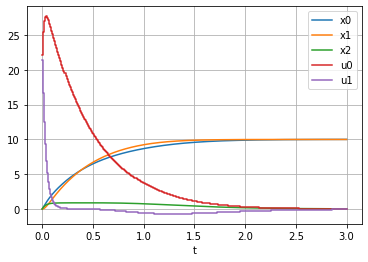

In [14]:
mpc_plot = Plot(mpc_simulator)
mpc_plot.plot_single()

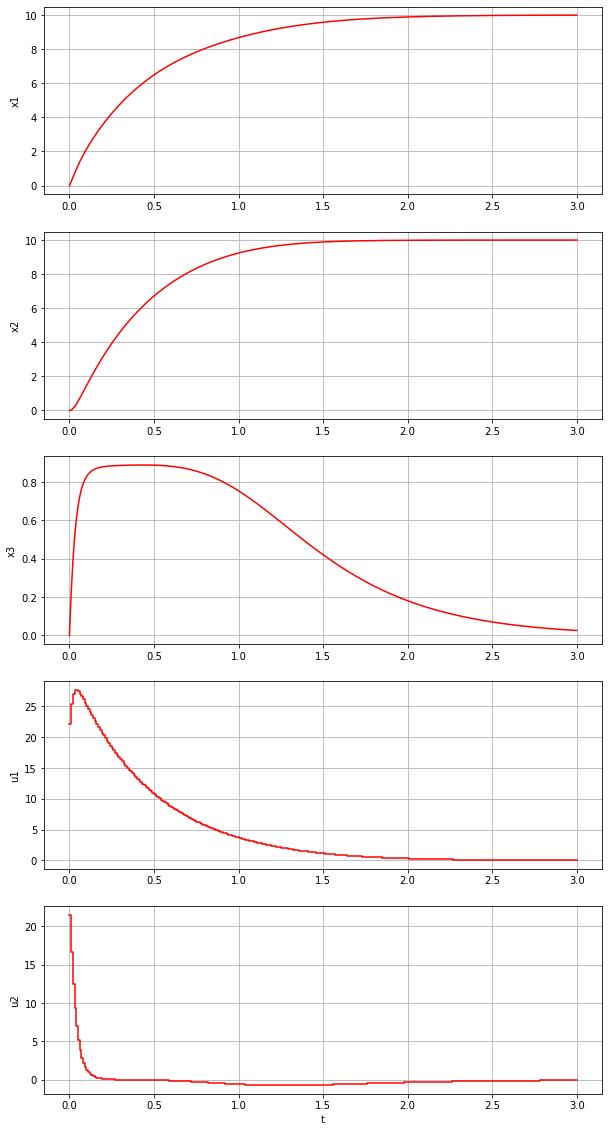

In [15]:
mpc_plot.plot_multi()